# Creating a Kaggle Workflow for the Titanic Competition

It is established that in machine learning, exponentially more things can go wrong as compared to standard software development. This can range from bugs in implementation, algorithm design to model issues and data quality. This results in exponentially more places that machine learning can go wrong. However, by defining a proper data science machine learning workflow, we can provide ourselves a framework with which to make iterating on ideas quicker and easier, allowing for greater efficiency. To reduce the number of dimensions we need to focus on, we can set up pipeline of functions to make working on the Kaggle's Titanic competition easier. The workflow would look like this:
![Image](https://s3.amazonaws.com/dq-content/188/kaggle_workflow.svg)

* **Data exploration**, to find patterns in the data
* **Feature engineering**, to create new features from those patterns or through pure experimentation
* **Feature selection**, to select the best subset of our current set of features
* **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

# Reading in the Dataset

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

From Kaggle, the Titanic competition provides two datasets - named as `train.csv` and `test.csv`, where the features are identical in both files but the `test.csv` has its target column - `Survived` removed which is what Kaggle calculates the accuracy scores on based on the predictions from our machine learning model when Kaggle checks against the actual values upon submission of our predictions onto Kaggle.

In [2]:
# Reading in the `train.csv` file
train = pd.read_csv("train.csv")

# Reading in the `test.csv` file which would be the holdout dataset used for final validation
holdout = pd.read_csv("test.csv")

In [3]:
# Looking at the first few rows of both dataframes
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


As mentioned earlier, the `Survived` column is removed from the `holdout` dataframe.

# Loading in Previous Functions Created

As part of simplifying data preprocessing, a few predefined functions have been created separately beforehand. These functions were created previously during the missions encountered on Dataquest. We can import in these functions for use later.

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

These functions above can be combined together to process an entire dataframe instead of applying each function individually.

In [6]:
# Combining the functions above to be applied on a dataframe
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"])
    return df

In [7]:
# Applying the process_df function to the `train` and `holdout` dataframes
train = process_df(train)
holdout = process_df(holdout)

# Data Exploration

In the first step of the workflow, we would be doing data exploration: finding patterns in the data. First, we are going to examine two columns that contain information about the family passengers each passenger had onboard: `SibSp` and `Parch`. From the data dictionary available on [Kaggle's website](https://www.kaggle.com/c/titanic/data) for the Titanic competition, the `SibSp` represents the number of siblings and spouses the passenger had onboard the Titanic and `Parch` represents the number of parents and children the passenger had onboard the Titanic.

In [8]:
# Inspecting the type of columns
train[['SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


Both columns are of the integer dtypes, which means there is no need to convert them as they are already numeric columns.

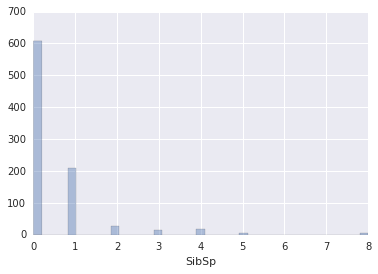

In [9]:
# Visualizing the distribution of the `SibSp` column
sns.distplot(train['SibSp'], kde=False)

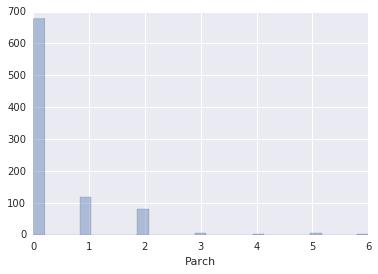

In [10]:
# Visualizing the distribution of the `Parch` column
sns.distplot(train['Parch'], kde=False)

Looking at the distribution of the values in these columns, it appears that most passengers are alone onboard the Titanic, without any siblings, spouses, parents or children. Both distributions are skewed to the right due to some passengers having large families onboard whom are the outliers in the dataset.

In [11]:
# Looking at the survival rates based on the different values of columns
train.pivot_table(index='SibSp', values='Survived')

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [12]:
train.pivot_table(index='Parch', values='Survived')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


Looking at the survival rates, it seems like passengers with more parents and children onboard are more likely to survive, likely owing to that these passengers must accompany them onboard the limited lifeboats which are reserved for children and the elderly (owing to domain knowledge from watching the Titanic movie). The relationship for number of siblings and spouses is not that clear though.

## Number of Relatives

The columns `SibSp` and `Parch` can be combined to represent the number of relatives each passenger had onboard the Titanic. Then, the distribution of the values and survival rate based on the number of relatives can be looked at.

In [13]:
# Combining the `SibSp` and `Parch` columns
train['Relatives'] = train['SibSp'] + train['Parch']

In [14]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,Relatives
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,0


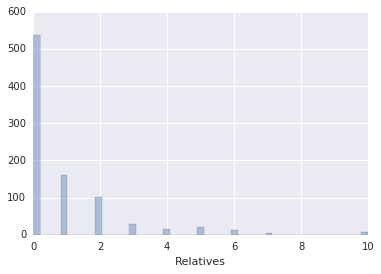

In [15]:
# Looking at the resulting distribution of the `Relatives` column
sns.distplot(train['Relatives'], kde=False)

The distribution of the `Relatives` column is similar to that of the `SibSp` and `Parch` columns since it is combined from them - skewed to the right.

In [16]:
# Looking at the survival rate based on number of relatives each passenger had onboard the Titanic
train.pivot_table(index='Relatives', values='Survived' )

,Survived
Relatives,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


From the findings, we can see that the greater the number of relatives each passenger had onboard the Titanic, the higher the chances of survival. More specifically, if the passenger was alone onboard the Titanic, the passenger only had approximately 30% chances of survival.

In [17]:
# Dropping the `Relatives` column after exploring
train.drop(columns='Relatives', inplace=True)

In [18]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0


# Engineering a New Feature

From above, we can come up with a new feature - was the passenger alone? This feature would be named `isalone` and would be represented as a binary column where the values are:
* 1 - if the passenger was alone, i.e. no relatives onboard
* 0 - if the passenger has at least one relative onboard

In [19]:
# Creating a function to create the `isalone` feature
def process_alone(df):
    alone_mask = (df['SibSp'] + df['Parch']) == 0
    df['isalone'] = 0
    df.loc[alone_mask, 'isalone'] = 1
    return df

In [20]:
# Applying the newly created function to the `train` and `holdout` dataframes
train = process_alone(train)
holdout = process_alone(holdout)

In [21]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,1


In [22]:
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,0,1,0,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,0,1,1,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,0,1,0,1,1


# Feature Selection

Next step is the workflow would be feature selection - selecting the best-performing features to train models on. We would employing RFECV and first, the random forests algorithm which tend to perform best, though at the possible risk of overfitting. We would be creating a function that performs the entire feature selection so as to speed up the workflow.

In [23]:
# Importing the relevant libraries
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [24]:
# Creating a function to perform the entire feature selection process and return the list of best features
def select_features(df):
    df = df.select_dtypes(include=[np.number]).dropna(axis=1)
    all_X = df.drop(columns=['PassengerId', 'Survived'])
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    best_features_mask = selector.support_
    best_features = all_X.columns[best_features_mask]
    return best_features

In [25]:
best_features = select_features(train)

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [26]:
best_features

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')

# Model Selection and Tuning

With feature selection out of the way, we would move on to model selection and tuning. Similar to what we did with feature selection, we would create a function that would do the entire model selection and tuning process so as to do the heavy lifting of model selection and tuning. The function would employ three different algorithms and use grid search for the hyperparameter optimization to find the best-performing model.

In [27]:
# Importing the relevant libraries
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [30]:
# Creation of function for model selection and tuning, taking in a dataframe and a list of features as parameters
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    models_list = [
        {
            'name':'LogisticRegression',
            'estimator':LogisticRegression(),
            'hyperparameters':{
                'solver':['newton-cg', 'lbfgs', 'liblinear']
            }
        },
        {
            'name':'KNeighborsClassifier',
            'estimator':KNeighborsClassifier(),
            'hyperparameters':{
                'n_neighbors':range(1,20,2),
                'weights':['distance', 'uniform'],
                'algorithm':['ball_tree', 'kd_tree', 'brute'],
                'p':[1,2]
            }
        },
        {
            'name':'RandomForestClassifier',
            'estimator':RandomForestClassifier(),
            'hyperparameters':{
                'n_estimators':[4, 6, 9],
                'criterion':['entropy', 'gini'],
                'max_depth':[2, 5, 10],
                'max_features':['log2', 'sqrt'],
                'min_samples_leaf':[1, 5, 8],
                'min_samples_split':[2, 3, 5]
            }
        }
    ]
    for model in models_list:
        print(model['name'])
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_estimator'] = grid.best_estimator_
        print('Best Parameters: {}'.format(grid.best_params_))
        print('Best Score: {}'.format(grid.best_score_))
    return models_list

In [31]:
# Running the model selection and tuning function on the train dataframe
selected_tuned_models = select_model(train, best_features)

LogisticRegression
Best Parameters: {'solver': 'liblinear'}
Best Score: 0.8204264870931538
KNeighborsClassifier
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'uniform', 'p': 1}
Best Score: 0.7755331088664422
RandomForestClassifier
Best Parameters: {'n_estimators': 9, 'min_samples_leaf': 1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'criterion': 'gini'}
Best Score: 0.8383838383838383


# Making a Submission to Kaggle

With the three models' scores out, we can proceed to test the best model (with the highest score) on the holdout set and return the predictions on the holdout set. Then, we can make a Kaggle submission with our holdout predictions. To enable us to continually submit to Kaggle should we wish to repeat the workflow cycle to find an even better model, we are going to create a function to help us automate the preparation of the submission file.

In [32]:
# Creation of function to automate the preparation of the submission file
def save_submission_file(best_trained_model, features, filename='submission.csv'):
    holdout_predictions = best_trained_model.predict(holdout[features])
    submission_dict = {'PassengerId':holdout['PassengerId'], 'Survived':holdout_predictions}
    submission = pd.DataFrame(submission_dict)
    submission.to_csv(filename, index=False)
    return

In [33]:
# Saving out a CSV of predictions based on the best trained model above and the best features for submission to Kaggle
save_submission_file(selected_tuned_models[2]['best_estimator'], best_features)

# Conclusion

With the submission file ready, we can now make our submission onto Kaggle. 